In [5]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [6]:
pip install -U -q --use-deprecated=legacy-resolver tf-models-official tensorflow

In [7]:
### https://saturncloud.io/blog/how-to-change-the-path-in-google-colab/
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/dataset')
pwd = '/content/drive/My Drive/Colab Notebooks/dataset'

Mounted at /content/drive


In [ ]:
## for weather data
# def data_preparation(data_name):
#     df = pd.read_csv(data_name)
#     sample_size = 50000
#     if data_name == 'shifts_canonical_train.csv':
#         df = df.sample( n = 80000, random_state = 1 , ignore_index = True)
#     else:
#         df = df.sample( n = sample_size, random_state = 1 , ignore_index = True)

#     df = df.dropna()

#     y = df['fact_temperature'].to_numpy()
#     y = y.reshape(-1,1)
#     df = df.iloc[:,6:]
#     X = df.to_numpy()
#     return X, y


In [ ]:
# from IPython.display import display
# pd.set_option('display.max_rows', 10)

In [8]:
def data_preparation(data):
    df = pd.read_csv(data)
    if data == "train.csv":
      df = df.sample(n= 40000, random_state=1)
    y = df.pop('power')
    y = y.to_numpy()
    y = y.reshape(-1,1)
    X = df.to_numpy()
    return X, y

In [9]:
X, y = data_preparation('train.csv')
seed = 23

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state= seed)

scaler1 = MinMaxScaler()
X_train = scaler1.fit_transform(X_train)
X_val = scaler1.transform(X_val)
X_test = scaler1.transform(X_test)

scaler2 = MinMaxScaler()
y_train = scaler2.fit_transform(y_train)
y_val = scaler2.transform(y_val)
y_test = scaler2.transform(y_test)
X_train.shape

(28800, 11)

In [11]:
X_small_shift, y_small_shift = data_preparation('dev_in.csv')
X_large_shift, y_large_shift = data_preparation('dev_out.csv')
print(X_small_shift.shape)

(18368, 11)


In [12]:
def normalization(X, y):
  scaler_1 = MinMaxScaler()
  scaler_2 = MinMaxScaler()
  X = scaler1.fit_transform(X)
  y = scaler2.fit_transform(y)
  return X, y

X_small_shift, y_small_shift = normalization(X_small_shift, y_small_shift)
X_large_shift, y_large_shift = normalization(X_large_shift, y_large_shift)

In [15]:
# OOD data 2
OOD_1 = pd.read_csv('Boston.csv')

OOD_1 = OOD_1.to_numpy()

OOD_1.shape

(506, 11)

In [16]:
# OOD data 2
OOD_2 = pd.read_csv('naval.csv')

OOD_2 = OOD_2.to_numpy()

OOD_2.shape

(11934, 11)

In [17]:
df_describe = pd.DataFrame(X_train)
df_describe.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000
mean,0.650062,0.690383,0.653303,0.499782,0.544147,0.313352,0.500530,0.498683,0.292670,0.555636,0.555636
std,0.214881,0.197573,0.157070,0.042184,0.170548,0.237956,0.118508,0.085208,0.162205,0.265017,0.265017
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.489362,0.539773,0.536877,0.475000,0.416376,0.121242,0.452119,0.460916,0.179511,0.368564,0.368564
50%,0.695035,0.738636,0.712665,0.500000,0.540255,0.253674,0.502471,0.496818,0.273519,0.584981,0.584981
75%,0.815603,0.852273,0.759804,0.525000,0.671184,0.460039,0.549502,0.535077,0.384339,0.779665,0.779665
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sklearn.datasets
import numpy as np

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import tensorflow as tf
tf.autograph.set_verbosity(0)
import official.nlp.modeling.layers as nlp_layers

tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [19]:
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)

  def call(self, inputs):
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)

    # Computes the ResNet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
      hidden += resid

    return self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(
        num_classes, **self.classifier_kwargs)

In [20]:
resnet_config = dict(num_classes = 1, num_layers= 3, num_hidden= 512)
resnet_model = DeepResNet(**resnet_config)
resnet_model.build( (None, 11) )
resnet_model.summary()

Model: "deep_res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  6144      
                                                                 
 dense_1 (Dense)             multiple                  262656    
                                                                 
 dense_2 (Dense)             multiple                  262656    
                                                                 
 dense_3 (Dense)             multiple                  262656    
                                                                 
 dense_4 (Dense)             multiple                  513       
                                                                 
Total params: 794625 (3.03 MB)
Trainable params: 788481 (3.01 MB)
Non-trainable params: 6144 (24.00 KB)
_________________________________________________________________


In [21]:
loss = tf.keras.losses.MeanSquaredError()
metrics = tf.keras.metrics.MeanSquaredError()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate= 1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 100,
                                            restore_best_weights = True)

fit_config = dict(batch_size= 512,  epochs= 1000,
                validation_data = (X_val, y_val),
                callbacks=[callback] )

In [ ]:
resnet_model.compile(**train_config)

history = resnet_model.fit( x = X_train, y = y_train,
                          batch_size= 512,
                          epochs= 1000,
                          callbacks=[callback],
                          validation_data = (X_val, y_val),
                          )

Epoch 1/1000
57/57 [==============================] - 8s 83ms/step - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 2/1000
57/57 [==============================] - 3s 60ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 3/1000
57/57 [==============================] - 5s 90ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 4/1000
57/57 [==============================] - 6s 99ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 5/1000
57/57 [==============================] - 4s 65ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 6/1000
57/57 [==============================] - 4s 62ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 7/1000
57/57 [==

<Axes: >

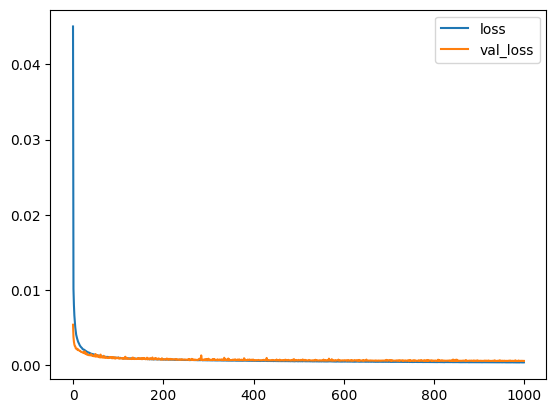

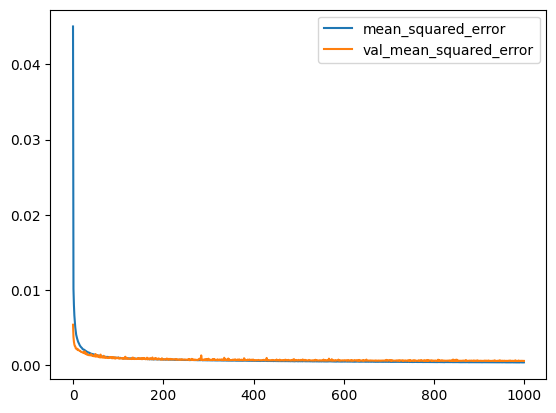

In [ ]:

history_df = pd.DataFrame(history.history)

history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['mean_squared_error', 'val_mean_squared_error']].plot()

# print(("Best Validation Loss: {:0.4f}" +\
#       "\nBest Validation Accuracy: {:0.4f}")\
#       .format(history_df['val_loss'].min(),
#               history_df['val_sparse_categorical_accuracy'].max()))

In [ ]:
resnet_model.evaluate(X_test, y_test)

250/250 [==============================] - 2s 7ms/step - loss: 5.0585e-04 - mean_squared_error: 5.0585e-04


[0.0005058473907411098, 0.0005058473907411098]

In [ ]:
resnet_model.evaluate(X_small_shift, y_small_shift)

574/574 [==============================] - 4s 7ms/step - loss: 5.7788e-04 - mean_squared_error: 5.7788e-04


[0.000577877857722342, 0.000577877857722342]

In [ ]:
resnet_model.evaluate(X_large_shift, y_large_shift)

574/574 [==============================] - 3s 5ms/step - loss: 0.0041 - mean_squared_error: 0.0041


[0.0041443705558776855, 0.0041443705558776855]

In [ ]:
#resnet_model.evaluate( scaler1.inverse_transform(X_test), scaler2.inverse_transform(y_test) )

In [ ]:
import official.nlp.modeling.layers as nlp_layers

In [ ]:
class DeepResNetSNGP(DeepResNet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier=self.spec_norm_bound)

  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes,
        gp_cov_momentum=-1,
        **self.classifier_kwargs)

  def call(self, inputs, training=False, return_covmat=False):
    # Gets logits and a covariance matrix from the GP layer.
    logits, covmat = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat:
      return logits, covmat

    return logits

In [ ]:
# Implement a Keras callback to reset the covariance matrix at the beginning of a new epoch.

In [ ]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

In [ ]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())
    return super().fit(*args, **kwargs)

In [ ]:
# Train model

In [ ]:
fit_config = dict(batch_size= 512, epochs= 1000,
               validation_data = (X_val, y_val),
               callbacks=[callback] )

In [ ]:
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model.compile(**train_config)
history = sngp_model.fit(X_train, y_train, **fit_config)

NameError: ignored

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.head()
history_df.loc[:, ['loss','val_loss']].plot()
#history_df.loc[:, ['sparse_categorical_accuracy']].plot()

NameError: ignored

In [ ]:
# # # First compute the predictive logits and variances.
# sngp_logits, sngp_covmat = sngp_model(X_test, return_covmat=True)

# sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
# std = np.sqrt(sngp_variance)
# print(np.mean(std))

In [ ]:
# # # Now compute the posterior predictive probability
# sngp_logits_adjusted = sngp_logits / tf.sqrt(1. + (np.pi / 8.) * sngp_variance)
# #sngp_probs = tf.nn.softmax(sngp_logits_adjusted, axis=-1)[:, 0]
# sngp_logits_adjusted

In [ ]:
# # This mean-field method is implemented as a built-in function layers.gaussian_process.mean_field_logits:

def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  # Computes uncertainty-adjusted logits using the built-in method.
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)

  return logits_adjusted

In [ ]:
# # This mean-field method is implemented as a built-in function layers.gaussian_process.mean_field_logits:

# def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
#   # Computes uncertainty-adjusted logits using the built-in method.
#   logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
#       logits, covmat, mean_field_factor=lambda_param)

#   return tf.nn.softmax(logits_adjusted, axis=-1)[:,0]

In [ ]:
sngp_logits, sngp_covmat = sngp_model(X_test, return_covmat=True)
sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
std = np.sqrt(sngp_variance)

print(np.mean(std))

sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(sngp_probs, y_test)
print(mse)

1425929.3437206123


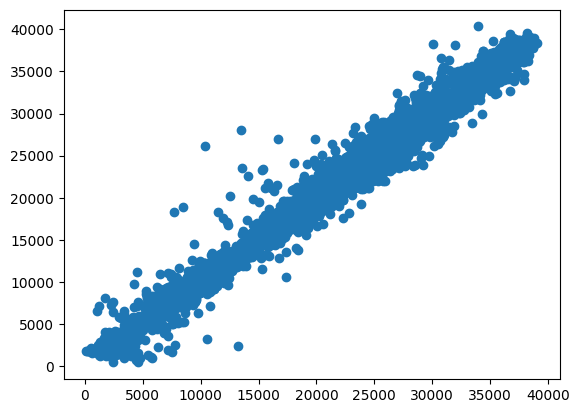

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
sngp_logits, sngp_covmat = sngp_model(X_small_shift, return_covmat=True)
sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
std = np.sqrt(sngp_variance)

print(np.mean(std))

sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)


mse = mean_squared_error(sngp_probs, y_small_shift)
print(mse)

In [ ]:
sngp_logits, sngp_covmat = sngp_model(X_large_shift, return_covmat=True)
sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
std = np.sqrt(sngp_variance)

print(np.mean(std))
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

mse = mean_squared_error(sngp_probs, y_large_shift)
print(mse)

In [ ]:
num_ensemble = 10

In [ ]:
def mc_dropout_sampling(test_examples):
  # Enable dropout during inference.
  return resnet_model(test_examples, training=True)

In [ ]:
# Monte Carlo dropout inference.
import seaborn as sns
pred_list = np.hstack([mc_dropout_sampling(X_test) for _ in range(num_ensemble)])

pred = pred_list.mean(axis = 1)

# plot one test point
sns.kdeplot(pred_list[0], fill=True)
plt.axvline(pred[0], color='red')
plt.show()

mse = mean_squared_error(pred, y_test)
print(mse)

std_list = [ np.std(i) for i in pred_list]
print(np.mean(std_list))


In [ ]:
import seaborn as sns
pred_list = np.hstack([mc_dropout_sampling(X_small_shift) for _ in range(num_ensemble)])

pred = pred_list.mean(axis = 1)

# plot one test point
sns.kdeplot(pred_list[0], fill=True)
plt.axvline(pred[0], color='red')
plt.show()

mse = mean_squared_error(pred, y_small_shift)
print(mse)

std_list = [ np.std(i) for i in pred_list]
print(np.mean(std_list))

In [ ]:
import seaborn as sns
pred_list = np.hstack([mc_dropout_sampling(X_large_shift) for _ in range(num_ensemble)])

pred = pred_list.mean(axis = 1)

# plot one test point
sns.kdeplot(pred_list[0], fill=True)
plt.axvline(pred[0], color='red')
plt.show()

mse = mean_squared_error(pred, y_large_shift)
print(mse)

std_list = [ np.std(i) for i in pred_list]
print(np.mean(std_list))

In [ ]:
num_ensemble = 10

In [ ]:
# Deep ensemble training
resnet_ensemble = []
for _ in range(num_ensemble):
  resnet_model = DeepResNet(**resnet_config)
  resnet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  resnet_model.fit(X_train, y_train, verbose=0, **fit_config)

  resnet_ensemble.append(resnet_model)

In [ ]:
# Deep ensemble inference


pred_list  = np.hstack([model(y_test) for model in resnet_ensemble])
pred = pred_list.mean(axis = 1)

# plot one test point
sns.kdeplot(pred_list[0], fill=True)
plt.axvline(pred[0], color='red')
plt.show()

mse = mean_squared_error(pred, y_test)
print(mse)

std_list = [ np.std(i) for i in pred_list]
print(np.mean(std_list))



In [ ]:
pred_list  = np.hstack([model(y_small_shift) for model in resnet_ensemble])
pred = pred_list.mean(axis = 1)

# plot one test point
sns.kdeplot(pred_list[0], fill=True)
plt.axvline(pred[0], color='red')
plt.show()

mse = mean_squared_error(pred, y_small_shift)
print(mse)

std_list = [ np.std(i) for i in pred_list]
print(np.mean(std_list))

In [ ]:
pred_list  = np.hstack([model(y_large_shift) for model in resnet_ensemble])
pred = pred_list.mean(axis = 1)

# plot one test point
sns.kdeplot(pred_list[0], fill=True)
plt.axvline(pred[0], color='red')
plt.show()

mse = mean_squared_error(pred, y_large_shift)
print(mse)

std_list = [ np.std(i) for i in pred_list]
print(np.mean(std_list))